In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate
import scipy.interpolate
import numpy as np
import scipy.stats as sts

n0 = 0.16e-15
pi = np.pi
MeV_to_km = 1.323e-6

In [101]:
EOS_small = pd.read_table('../data/EOSCEFTVE1.dat', header=None).to_numpy()

We are going to extend this table through the speed of sound. We are using the speed of sound because of it's definition:

$$ c_s^2 = \frac{\partial p(\epsilon)}{\partial \epsilon} $$

The mechanics will work like Ingo et. al. where we step the baryon density, $n$, by a small $\Delta n$,

$$ n_{i+1} = n_i + \Delta n $$

where $i$ is the index of our data array. Then we use the speed of sound, $c_s$, and a thermodynamic identity to get the energy density and pressure.

$$
\begin{align}
    \epsilon_{i+1} &= \epsilon_i + \Delta n \left( \frac{\epsilon_i + p_i}{n_i} \right)\\
    p_{i+1} &= p_i + c_s^2(n_i) \Delta n \left( \frac{\epsilon_i + p_i}{n_i} \right)
\end{align}
$$
    
We will be defining our speed of sound curve in this notebook by specifying its value at a number of points and just connecting the two with linear segments. The speed of sound (in units where c=1) must be between 0 and 1 to keep causality.

To begin, let's get the speed of sound in the range we already have (n < 2n0).

In [110]:
n = EOS_small[:,0]
e = MeV_to_km*EOS_small[:,1]
p = MeV_to_km*EOS_small[:,2]

dp_de = scipy.interpolate.CubicSpline(e, p).derivative(nu=1)

c_s_2n0 = np.sqrt(1/dp_de(e[-1]))
print(c_s_2n0)

0.3654078562510514


In [37]:
def sample_cs(num_points, max_n, n_start, cs_start):
    
    n = np.linspace(n_start, max_n, num_points+1, endpoint=True)
    c = cs_start*np.ones(1)
    sample_cs = sts.uniform.rvs(size=num_points)
    cs = np.append(c, sample_cs)
    
    return n, cs

In [91]:
num_points = 4
n_start = 2*n0
max_n = 10*n0

ns, cs = sample_cs(num_points, max_n, n_start, c_s_2n0)

print(ns, cs)

cs_func = scipy.interpolate.interp1d(ns[0:2], cs[0:2])

print(cs_func(ns[1]))

[3.20e-16 6.40e-16 9.60e-16 1.28e-15 1.60e-15] [0.36540786 0.30538199 0.82017655 0.84059202 0.12302385]
0.3053819918804219


In [92]:
size = 400
true_size = num_points*size + 1

# initialize array
EOS_ex = np.zeros((true_size, 3))
# set starting values at n = 2n0
EOS_ex[0,0] = n_start
EOS_ex[0,1] = e[-1]
EOS_ex[0,2] = p[-1]

for i in range(num_points):
    
    n_step = (ns[i+1] - ns[i])/size
    cs_func = scipy.interpolate.interp1d(ns[i:i+2], cs[i:i+2])
    EOS_ex[i*size,0] = ns[i]
    
    for j in range(size):
        
        k = size*i+j
        
        # n_i+1
        EOS_ex[k+1,0] = EOS_ex[k,0] + n_step
        # e_i+1
        EOS_ex[k+1,1] = EOS_ex[k,1] + n_step*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])
        # p_i+1
        EOS_ex[k+1,2] = EOS_ex[k,2] + n_step*cs_func(EOS_ex[k,0])*((EOS_ex[k,1]+EOS_ex[k,2])/EOS_ex[k,0])

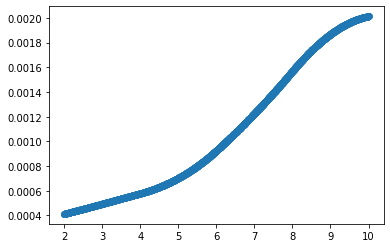

In [108]:
plt.plot(EOS_ex[:,0]/n0, EOS_ex[:,2], 'o')

In [116]:
def stitch_EOS(small_EOS, EOS_ex):
    size_smol = small_EOS.shape[0]
    size_ex = EOS_ex.shape[0]
    
    tot_EOS = np.zeros((size_smol+size_ex, small_EOS.shape[1]))
    
    tot_EOS[:size_smol,0] = small_EOS[:,0]*n0
    tot_EOS[:size_smol,0:]
    tot_EOS[size_smol:,:] = EOS_ex
    
    return tot_EOS

In [117]:
tot_EOS = stitch_EOS(EOS_small, EOS_ex)

print(tot_EOS.shape, EOS_small.shape[0]+EOS_ex.shape[0])

(3251, 3) 3251


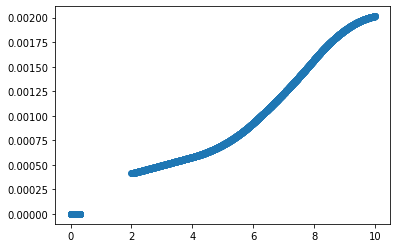

In [118]:
plt.plot(tot_EOS[:,0]/n0, tot_EOS[:,2], 'o')

In [89]:
import real_TOVsolver

EOS_test = pd.read_table('../data/EOS_test.dat', header=None)
max_pressure = 350 #MeV/fm3
MRL_test = real_TOVsolver.solve(EOS_test, max_pressure)

KeyError: 1